<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт бибилиотек и функции

In [1]:
# импорт нужных бибилиотек
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

from tensorflow.keras.applications.xception import Xception

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=12, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=12, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='Greens', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=12, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  model_roc_auc = roc_auc_score(y_true, y_probabilities)


  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  return

def plot_roc_curve(y_test, y_prob):
  plt.figure(figsize=(5, 4))
  auc = roc_auc_score(y_test, y_prob)
  fper, tper, thresholds = roc_curve(y_test, y_prob)
  plt.plot(fper, tper, color="green", label=f"AUC = {round(auc, 3)}")
  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.xlabel("False Positive Rate", fontsize=12)
  plt.ylabel("True Positive Rate", fontsize=12)
  plt.title("График ROC-кривой", fontsize=12, fontweight="bold")
  plt.grid()
  plt.legend(loc=4)
  plt.show()

## Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 14 01:22 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops

100% 2.36G/2.37G [00:28<00:00, 96.0MB/s]
100% 2.37G/2.37G [00:28<00:00, 88.3MB/s]


## Чтение данных

In [7]:
# разархивирование данных
!unzip "/content/weed-detection-in-soybean-crops.zip" -d "/content/weed_detection"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/weed_detection/dataset/soybean/3137.tif  
  inflating: /content/weed_detection/dataset/soybean/3138.tif  
  inflating: /content/weed_detection/dataset/soybean/3139.tif  
  inflating: /content/weed_detection/dataset/soybean/314.tif  
  inflating: /content/weed_detection/dataset/soybean/3140.tif  
  inflating: /content/weed_detection/dataset/soybean/3141.tif  
  inflating: /content/weed_detection/dataset/soybean/3142.tif  
  inflating: /content/weed_detection/dataset/soybean/3143.tif  
  inflating: /content/weed_detection/dataset/soybean/3144.tif  
  inflating: /content/weed_detection/dataset/soybean/3145.tif  
  inflating: /content/weed_detection/dataset/soybean/3146.tif  
  inflating: /content/weed_detection/dataset/soybean/3147.tif  
  inflating: /content/weed_detection/dataset/soybean/3148.tif  
  inflating: /content/weed_detection/dataset/soybean/3149.tif  
  inflating: /content/weed_detection/

In [8]:
labels = ["soil", "soybean"]

In [9]:
X  =[]
Y = []
image_size = (32, 32)

for i in labels:
    Datasetspath = "/content/weed_detection/dataset/dataset/" + i + "/"
    print(Datasetspath)
    fileRead = glob.glob(Datasetspath + "*")
    print(len(fileRead))

    for file in fileRead:
        image = cv2.imread(file)
        img = cv2.resize(image, image_size)
        X.append(img)
        Y.append(i)
X = np.array(X)
Y = np.array(Y)

/content/weed_detection/dataset/dataset/soil/
3249
/content/weed_detection/dataset/dataset/soybean/
7376


# Исследование данных

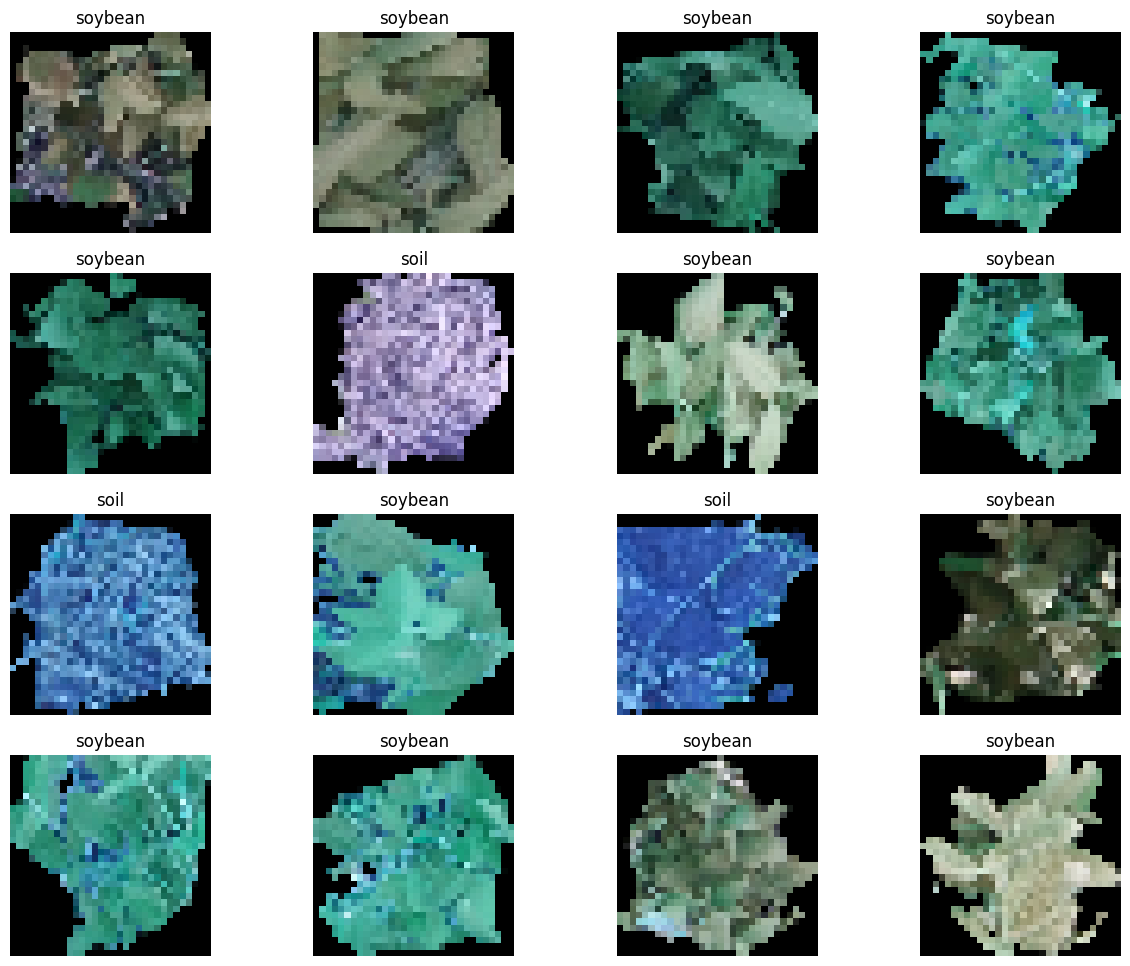

In [10]:
plt.figure(figsize=(15, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    random_index = random.randint(0, len(X) - 1)
    plt.imshow(X[random_index])
    plt.title(Y[random_index])
    plt.axis('off')

In [11]:
# конвертируем названия классов в метки
lb = LabelEncoder()
y = lb.fit_transform(Y)
class_names = lb.classes_
class_names

array(['soil', 'soybean'], dtype='<U7')

# Деление на выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 6800
Размер валидационной выборки: 1700
Размер тестовой выборки: 2125


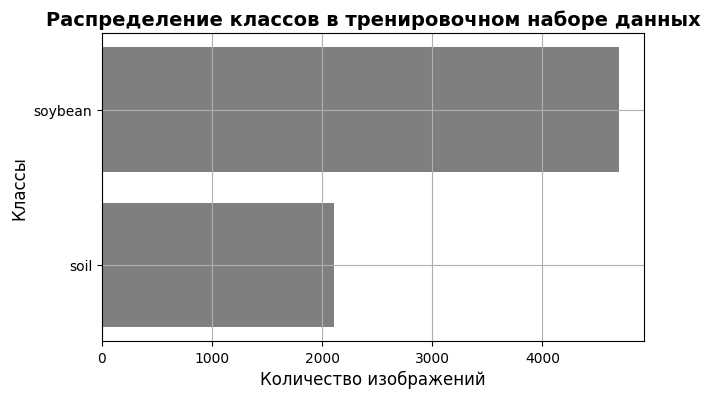

In [13]:
# количество изображений в тренировочной выборке на каждй класс
train = pd.DataFrame(y_train)[0].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.figure(figsize=(7, 4))
plt.title("Распределение классов в тренировочном наборе данных", fontsize=14, fontweight="bold")
plt.xlabel("Количество изображений", fontsize=12)
plt.ylabel("Классы", fontsize=12)
plt.barh(index, label, color="#7f7f7f")
plt.yticks([0, 1], ['soil', 'soybean'])
plt.grid(True)
plt.show()

# Обучение без аугментации (бинарный)

In [14]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [29]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 2)         8         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 2)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [30]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 2s 8ms/step - loss: 0.0813 - accuracy: 0.9710 - val_loss: 0.0055 - val_accuracy: 0.9982
Epoch 2/10
213/213 [==============================] - 2s 9ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.1375 - val_accuracy: 0.9553
Epoch 3/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.0046 - val_accuracy: 0.9994
Epoch 4/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9988
Epoch 5/10
213/213 [==============================] - 2s 8ms/step - loss: 0.0132 - accuracy: 0.9951 - val_loss: 0.1221 - val_accuracy: 0.9776
Epoch 6/10
213/213 [==============================] - 1s 7ms/step - loss: 0.0254 - accuracy: 0.9951 - val_loss: 0.0161 - val_accuracy: 0.9988
Epoch 7/10
213/213 [==============================] - 2s 7ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch

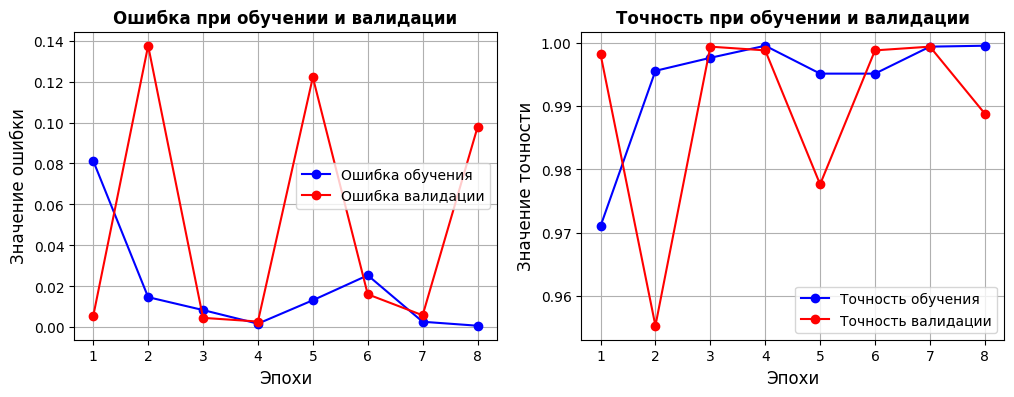

In [31]:
plot_training_curves(history)

In [32]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

67/67 [==============================] - 0s 3ms/step


In [33]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9883
Precision_score:	0.9900
Recall_score:		1.0000
AUC Score:		0.9976


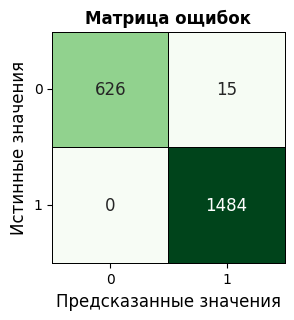

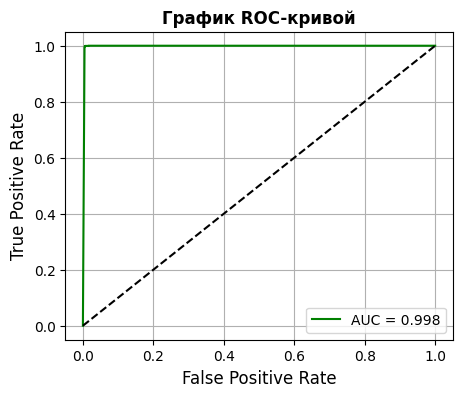

In [34]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [35]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.SGD()

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 2)         8         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 2)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [36]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 2s 8ms/step - loss: 0.4039 - accuracy: 0.8378 - val_loss: 0.2191 - val_accuracy: 0.9500
Epoch 2/10
213/213 [==============================] - 1s 6ms/step - loss: 0.1456 - accuracy: 0.9906 - val_loss: 0.0972 - val_accuracy: 0.9953
Epoch 3/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0764 - accuracy: 0.9969 - val_loss: 0.0601 - val_accuracy: 0.9988
Epoch 4/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0506 - accuracy: 0.9976 - val_loss: 0.0432 - val_accuracy: 0.9988
Epoch 5/10
213/213 [==============================] - 1s 7ms/step - loss: 0.0381 - accuracy: 0.9978 - val_loss: 0.0345 - val_accuracy: 0.9988
Epoch 6/10
213/213 [==============================] - 1s 7ms/step - loss: 0.0306 - accuracy: 0.9978 - val_loss: 0.0278 - val_accuracy: 0.9988
Epoch 7/10
213/213 [==============================] - 1s 6ms/step - loss: 0.0258 - accuracy: 0.9978 - val_loss: 0.0240 - val_accuracy: 0.9988
Epoch 

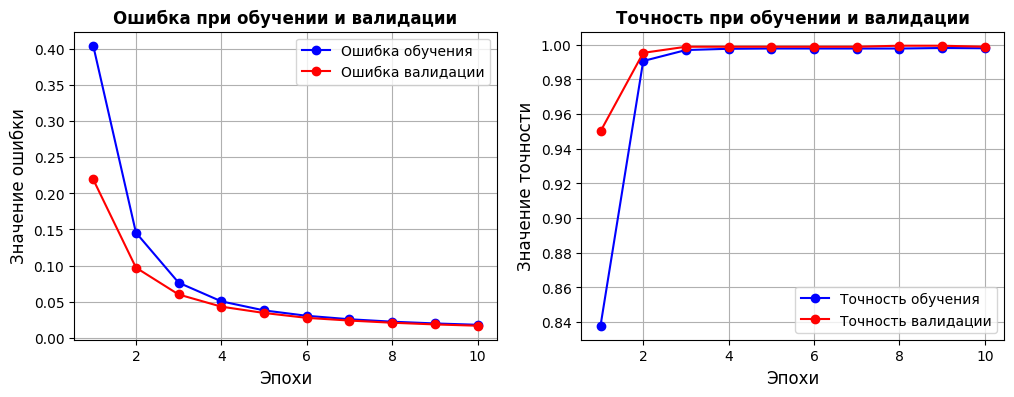

In [37]:
plot_training_curves(history)

In [38]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

67/67 [==============================] - 0s 3ms/step


In [39]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9982
Precision_score:	0.9993
Recall_score:		0.9980
AUC Score:		1.0000


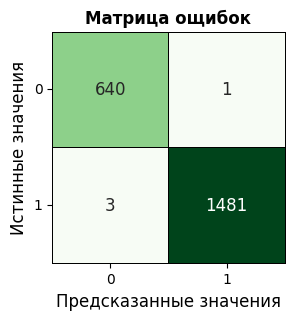

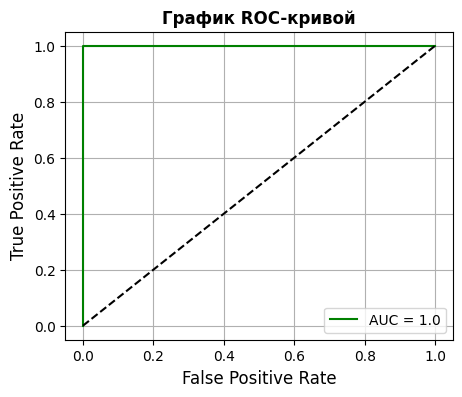

In [40]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 3

In [41]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(4, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 31, 31, 4)         52        
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 15, 15, 4)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 900)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 901       
                                                                 
Total params: 953 (3.72 KB)
Trainable params: 953 (3.72 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [42]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 4s 14ms/step - loss: 0.3316 - accuracy: 0.8494 - val_loss: 0.0330 - val_accuracy: 0.9982
Epoch 2/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0176 - accuracy: 0.9994 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 3/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0080 - accuracy: 0.9994 - val_loss: 0.0077 - val_accuracy: 0.9994
Epoch 4/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0061 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 0.9994
Epoch 5/10
213/213 [==============================] - 4s 17ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 0.0036 - val_accuracy: 0.9994
Epoch 6/10
213/213 [==============================] - 2s 11ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/10
213/213 [==============================] - 3s 14ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0027 - val_accuracy: 0.9994

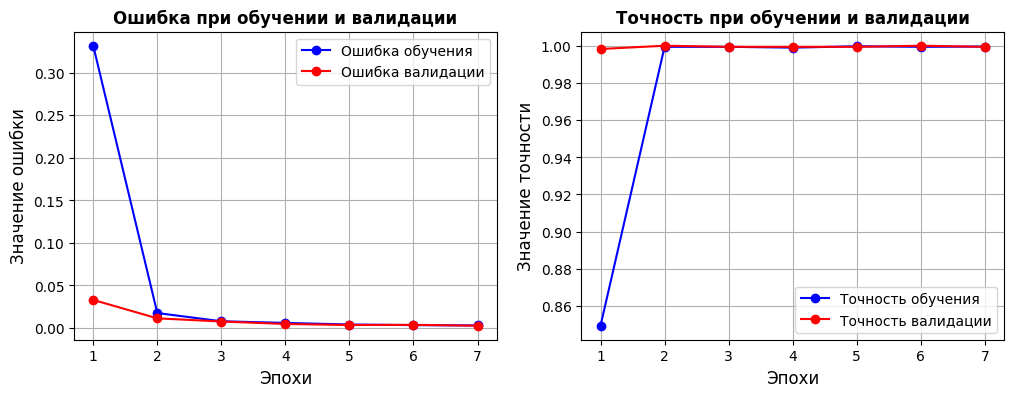

In [43]:
plot_training_curves(history)

In [44]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

67/67 [==============================] - 0s 6ms/step


In [45]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9993
Precision_score:	1.0000
Recall_score:		0.9987
AUC Score:		1.0000


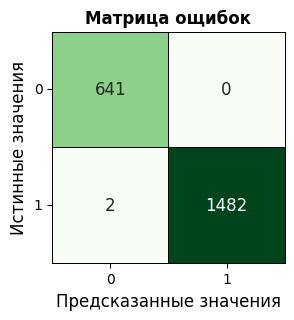

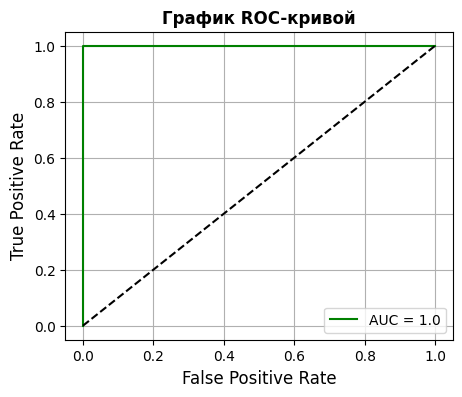

In [46]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 4

In [47]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 4)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 900)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 901       
                                                                 
Total params: 1013 (3.96 KB)
Trainable params: 1013 (3.96 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

In [48]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 3s 13ms/step - loss: 0.5256 - accuracy: 0.7497 - val_loss: 0.3954 - val_accuracy: 0.8906
Epoch 2/10
213/213 [==============================] - 4s 18ms/step - loss: 0.2970 - accuracy: 0.9681 - val_loss: 0.2141 - val_accuracy: 0.9900
Epoch 3/10
213/213 [==============================] - 3s 14ms/step - loss: 0.1613 - accuracy: 0.9950 - val_loss: 0.1212 - val_accuracy: 0.9959
Epoch 4/10
213/213 [==============================] - 3s 12ms/step - loss: 0.0951 - accuracy: 0.9975 - val_loss: 0.0764 - val_accuracy: 0.9982
Epoch 5/10
213/213 [==============================] - 3s 12ms/step - loss: 0.0624 - accuracy: 0.9985 - val_loss: 0.0528 - val_accuracy: 0.9988
Epoch 6/10
213/213 [==============================] - 3s 12ms/step - loss: 0.0443 - accuracy: 0.9993 - val_loss: 0.0390 - val_accuracy: 1.0000
Epoch 7/10
213/213 [==============================] - 4s 21ms/step - loss: 0.0333 - accuracy: 0.9991 - val_loss: 0.0302 - val_accuracy: 0.9994

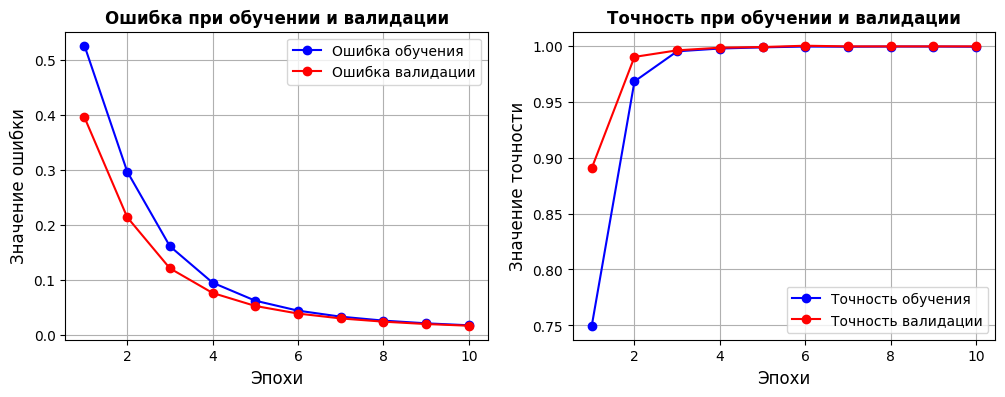

In [49]:
plot_training_curves(history)

In [50]:
y_predicted_prob = model.predict(X_test)
y_predicted = (y_predicted_prob > 0.5).astype(int)

67/67 [==============================] - 0s 5ms/step


In [51]:
model_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9989
Precision_score:	0.9993
Recall_score:		0.9993
AUC Score:		1.0000


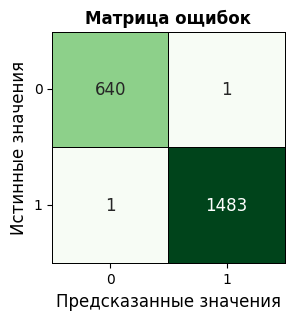

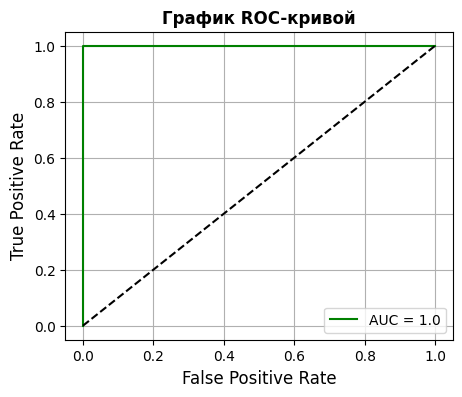

In [52]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 5

In [53]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 4)         112       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 4)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 4)         0         
                                                                 
 flatten_7 (Flatten)         (None, 900)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 901       
                                                      

In [54]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 5s 19ms/step - loss: 0.6022 - accuracy: 0.6872 - val_loss: 0.5320 - val_accuracy: 0.7071
Epoch 2/10
213/213 [==============================] - 3s 13ms/step - loss: 0.4840 - accuracy: 0.7587 - val_loss: 0.3956 - val_accuracy: 0.8547
Epoch 3/10
213/213 [==============================] - 3s 13ms/step - loss: 0.3364 - accuracy: 0.8944 - val_loss: 0.2544 - val_accuracy: 0.9406
Epoch 4/10
213/213 [==============================] - 3s 13ms/step - loss: 0.2113 - accuracy: 0.9624 - val_loss: 0.1554 - val_accuracy: 0.9876
Epoch 5/10
213/213 [==============================] - 4s 20ms/step - loss: 0.1301 - accuracy: 0.9897 - val_loss: 0.0978 - val_accuracy: 0.9953
Epoch 6/10
213/213 [==============================] - 3s 13ms/step - loss: 0.0851 - accuracy: 0.9956 - val_loss: 0.0660 - val_accuracy: 0.9976
Epoch 7/10
213/213 [==============================] - 3s 13ms/step - loss: 0.0587 - accuracy: 0.9984 - val_loss: 0.0475 - val_accuracy: 0.9994

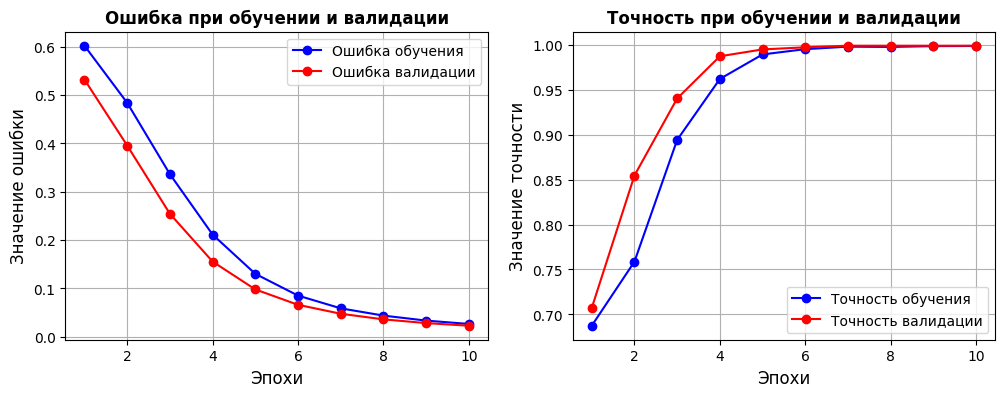

In [55]:
plot_training_curves(history)

In [56]:
y_predicted_prob = model.predict(X_test)
y_predicted = (y_predicted_prob > 0.5).astype(int)

67/67 [==============================] - 0s 6ms/step


In [57]:
model_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9997
Precision_score:	1.0000
Recall_score:		0.9993
AUC Score:		1.0000


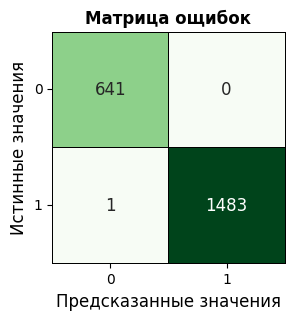

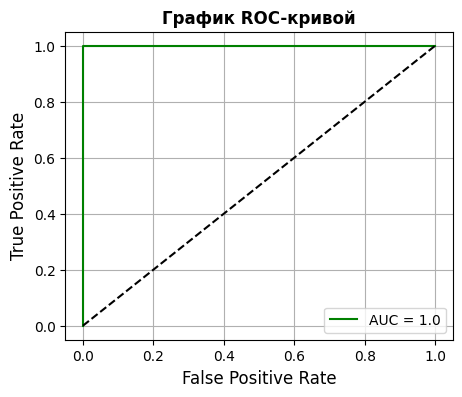

In [58]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

# Обучение аугментация (бинарный)

In [60]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.15,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.15,
  horizontal_flip=True,
  fill_mode="nearest")

## Модель 1

In [62]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 2)         8         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 2)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

In [63]:
history = model.fit(x=aug.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 12s 54ms/step - loss: 0.1612 - accuracy: 0.9565 - val_loss: 0.1271 - val_accuracy: 0.9712
Epoch 2/10
213/213 [==============================] - 5s 25ms/step - loss: 0.0215 - accuracy: 0.9941 - val_loss: 0.0050 - val_accuracy: 0.9994
Epoch 3/10
213/213 [==============================] - 5s 25ms/step - loss: 0.0176 - accuracy: 0.9954 - val_loss: 0.0048 - val_accuracy: 0.9994
Epoch 4/10
213/213 [==============================] - 5s 26ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.0025 - val_accuracy: 0.9994
Epoch 5/10
213/213 [==============================] - 6s 29ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 6/10
213/213 [==============================] - 6s 28ms/step - loss: 0.0262 - accuracy: 0.9929 - val_loss: 0.0254 - val_accuracy: 0.9959
Epoch 7/10
213/213 [==============================] - 5s 25ms/step - loss: 0.0877 - accuracy: 0.9881 - val_loss: 0.0051 - val_accuracy: 0.999

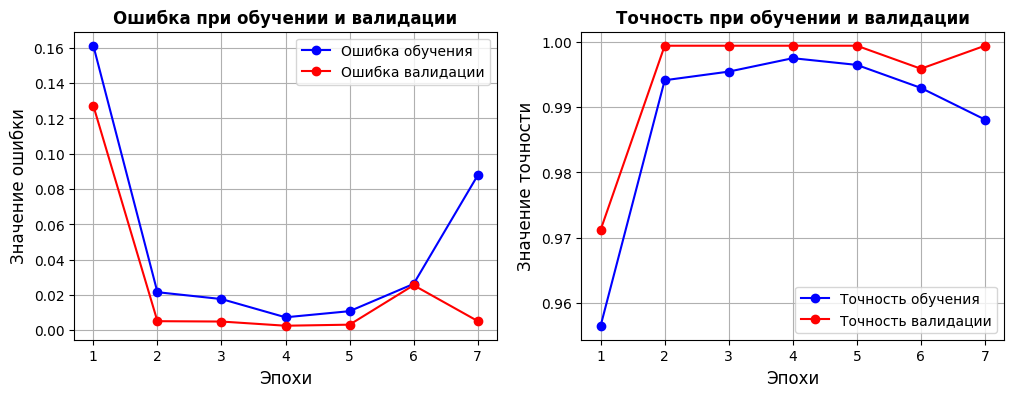

In [64]:
plot_training_curves(history)

In [65]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

67/67 [==============================] - 0s 3ms/step


In [66]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9982
Precision_score:	0.9993
Recall_score:		0.9980
AUC Score:		1.0000


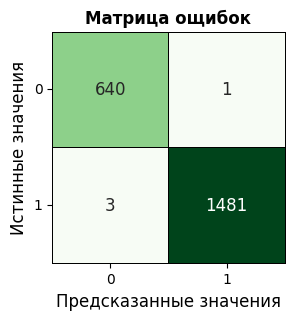

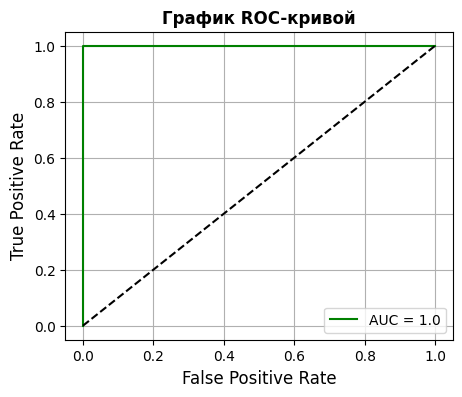

In [67]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [68]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.SGD()

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 2)         8         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 2)         0         
 ng2D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 521 (2.04 KB)
Trainable params: 521 (2.04 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

In [69]:
history = model.fit(x=aug.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
213/213 [==============================] - 6s 26ms/step - loss: 0.5334 - accuracy: 0.7401 - val_loss: 0.3745 - val_accuracy: 0.9094
Epoch 2/10
213/213 [==============================] - 5s 25ms/step - loss: 0.2705 - accuracy: 0.9335 - val_loss: 0.1495 - val_accuracy: 0.9771
Epoch 3/10
213/213 [==============================] - 5s 25ms/step - loss: 0.1242 - accuracy: 0.9865 - val_loss: 0.0774 - val_accuracy: 0.9971
Epoch 4/10
213/213 [==============================] - 6s 30ms/step - loss: 0.0723 - accuracy: 0.9951 - val_loss: 0.0490 - val_accuracy: 0.9976
Epoch 5/10
213/213 [==============================] - 8s 37ms/step - loss: 0.0505 - accuracy: 0.9985 - val_loss: 0.0352 - val_accuracy: 0.9988
Epoch 6/10
213/213 [==============================] - 6s 30ms/step - loss: 0.0387 - accuracy: 0.9985 - val_loss: 0.0303 - val_accuracy: 0.9982
Epoch 7/10
213/213 [==============================] - 7s 32ms/step - loss: 0.0317 - accuracy: 0.9990 - val_loss: 0.0241 - val_accuracy: 0.9982

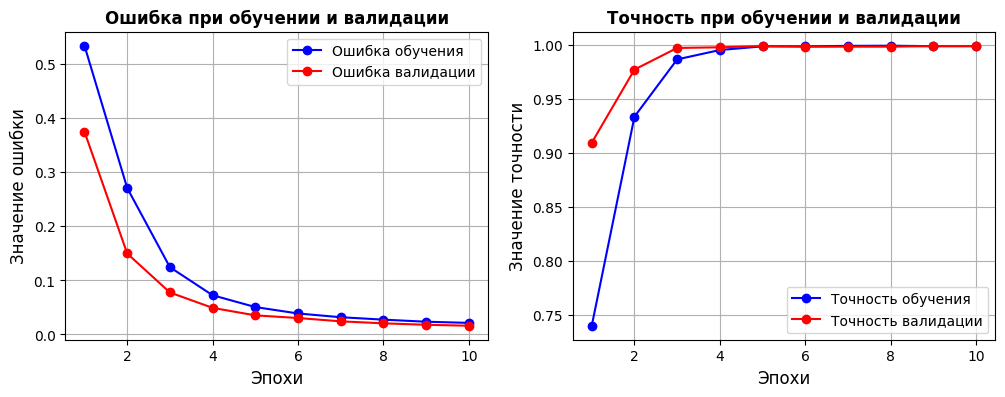

In [70]:
plot_training_curves(history)

In [71]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

67/67 [==============================] - 0s 3ms/step


In [72]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9979
Precision_score:	0.9993
Recall_score:		0.9973
AUC Score:		0.9999


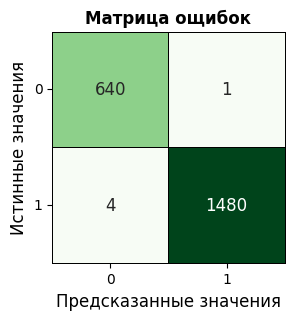

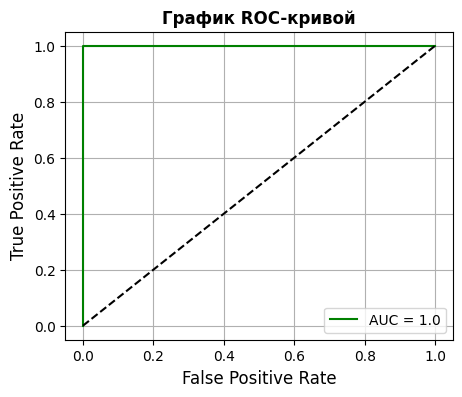

In [73]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

# Чтение данных

In [11]:
labels = ["soil", "soybean", "grass"]
IMG_SIZE = 71

In [12]:
X  =[]
Y = []
image_size = (IMG_SIZE, IMG_SIZE)

for i in labels:
    Datasetspath = "/content/weed_detection/dataset/dataset/" + i + "/"
    print(Datasetspath)
    fileRead = glob.glob(Datasetspath + "*")
    print(len(fileRead))

    for file in fileRead:
        image = cv2.imread(file)
        img = cv2.resize(image, image_size)
        X.append(img)
        Y.append(i)
X = np.array(X)
Y = np.array(Y)

/content/weed_detection/dataset/dataset/soil/
3249
/content/weed_detection/dataset/dataset/soybean/
7376
/content/weed_detection/dataset/dataset/grass/
3520


# Исследование данных

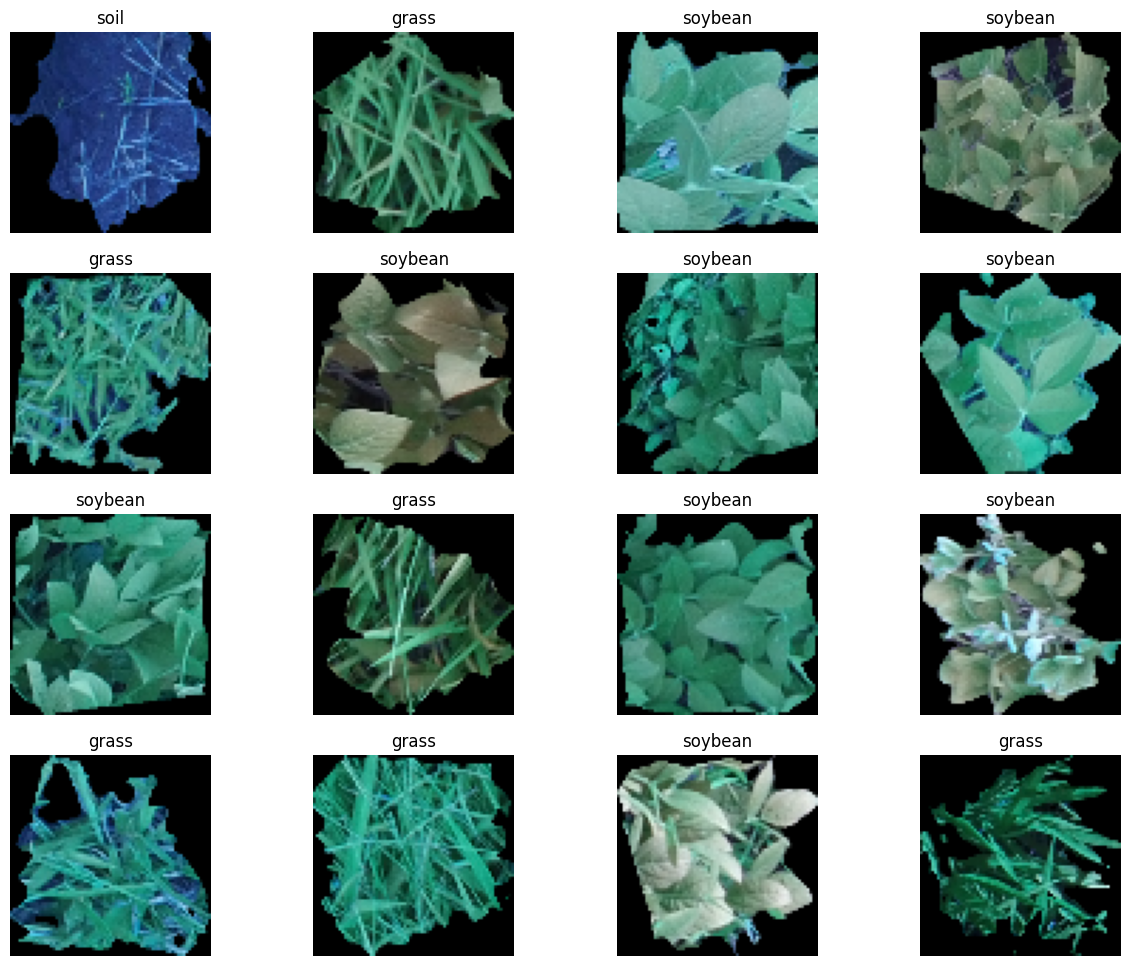

In [13]:
plt.figure(figsize=(15, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    random_index = random.randint(0, len(X) - 1)
    plt.imshow(X[random_index])
    plt.title(Y[random_index])
    plt.axis('off')

In [24]:
# конвертируем названия классов в метки
lb = LabelEncoder()
y = lb.fit_transform(Y)
class_names = lb.classes_
class_names

array(['grass', 'soil', 'soybean'], dtype='<U7')

# Деление на выборки

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 9052
Размер валидационной выборки: 2264
Размер тестовой выборки: 2829


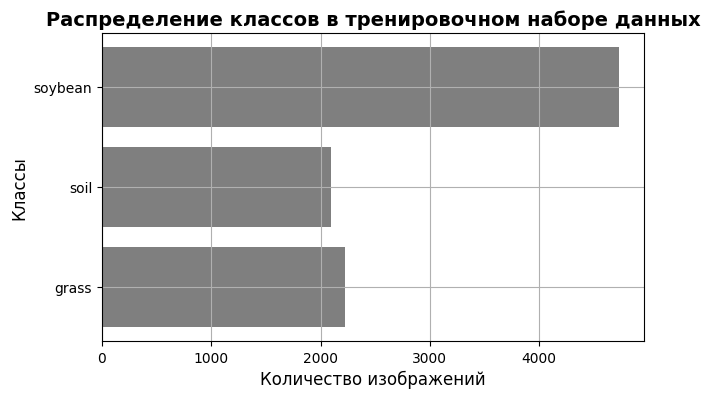

In [33]:
# количество изображений в тренировочной выборке на каждй класс
train = pd.DataFrame(y_train)[0].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.figure(figsize=(7, 4))
plt.title("Распределение классов в тренировочном наборе данных", fontsize=14, fontweight="bold")
plt.xlabel("Количество изображений", fontsize=12)
plt.ylabel("Классы", fontsize=12)
plt.barh(index, label, color="#7f7f7f")
plt.yticks([0, 1, 2], ['grass', 'soil', 'soybean'])
plt.grid(True)
plt.show()

In [70]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Дообучение с заключительными ПС

In [17]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

callbacks_list=[early_stop]

In [ ]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report


def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='PuBu', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  cm = confusion_matrix(y_test, y_predicted)
  accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')
  print("")
  for i in range(len(accuracy_per_class)):
    print(f"Accuracy Score {i}:\t{accuracy_per_class[i]:.4f}")
  print("")
  print(classification_report(y_test, y_predicted))

  return

def plot_multiclass_roc(y_test, y_prob, n_classes, figsize=(5,5)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = %0.3f for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

## Модель 1

In [18]:
base_model = Xception(
                    weights='imagenet',
                    include_top=False,
                    input_shape = (IMG_SIZE, IMG_SIZE, 3))

83683744/83683744 [==============================] - 0s 0us/step


In [41]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 16)                32784     
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 51        
                                                                 
Total params: 20894315 (79.71 MB)
Trainable params: 20839787 (79.50 MB)
Non-trainable params: 54528 (213.00 KB)
________

In [42]:
history = model.fit(X_train,
                    y_train,
                    epochs=1,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

283/283 [==============================] - 1136s 4s/step - loss: 0.0755 - accuracy: 0.9779 - val_loss: 0.4284 - val_accuracy: 0.9907


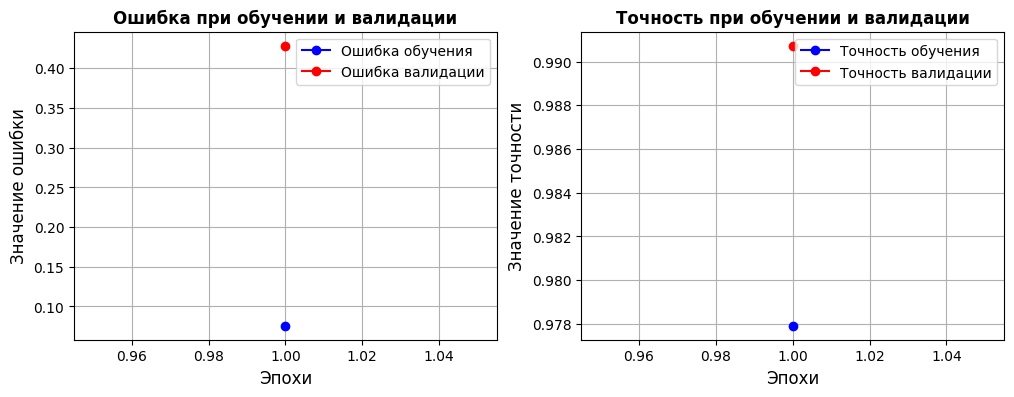

In [43]:
plot_training_curves(history)

In [49]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

89/89 [==============================] - 60s 669ms/step


In [61]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9928
Precision_score:	0.9919
Recall_score:		0.9919
F1_score:		0.9919
AUC Score:		0.9994

Accuracy Score 0:	0.9885
Accuracy Score 1:	1.0000
Accuracy Score 2:	0.9898

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       695
           1       0.99      1.00      0.99       660
           2       1.00      0.99      0.99      1474

    accuracy                           0.99      2829
   macro avg       0.99      0.99      0.99      2829
weighted avg       0.99      0.99      0.99      2829



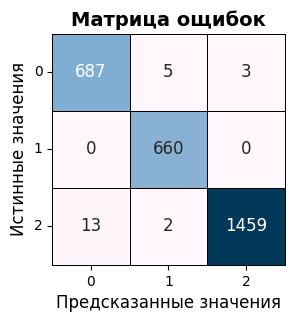

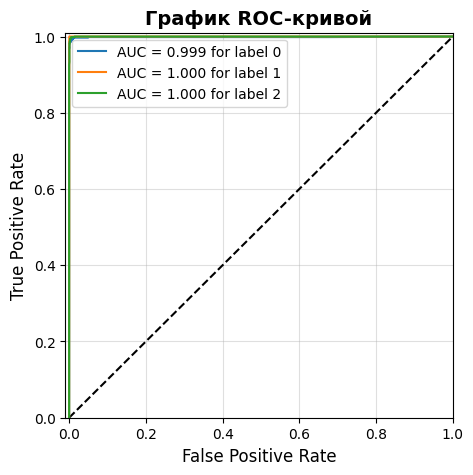

In [65]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_multiclass_roc(y_test, y_predicted_prob, 3)

# Дообучение fine-tuning

## Модель 1

In [72]:
base_model = Xception(
                    weights='imagenet',
                    include_top=False,
                    input_shape = (IMG_SIZE, IMG_SIZE, 3))

base_model.trainable = False

In [73]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 16)                32784     
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 3)                 51        
                                                                 
Total params: 20894315 (79.71 MB)
Trainable params: 32835 (128.26 KB)
Non-trainable params: 20861480 (79.58 MB)
________

In [74]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
283/283 [==============================] - 279s 977ms/step - loss: 1.1079 - accuracy: 0.5197 - val_loss: 0.8399 - val_accuracy: 0.5194
Epoch 2/10
283/283 [==============================] - 271s 958ms/step - loss: 0.9104 - accuracy: 0.5222 - val_loss: 0.8030 - val_accuracy: 0.5194
Epoch 3/10
283/283 [==============================] - 274s 971ms/step - loss: 0.8939 - accuracy: 0.5222 - val_loss: 0.8151 - val_accuracy: 0.5194
Epoch 4/10
283/283 [==============================] - 271s 959ms/step - loss: 0.9068 - accuracy: 0.5221 - val_loss: 0.7692 - val_accuracy: 0.5194
Epoch 5/10
283/283 [==============================] - 271s 959ms/step - loss: 0.8699 - accuracy: 0.5221 - val_loss: 0.7632 - val_accuracy: 0.5194
Epoch 6/10
283/283 [==============================] - 273s 966ms/step - loss: 0.8427 - accuracy: 0.5222 - val_loss: 0.8213 - val_accuracy: 0.5194
Epoch 6: early stopping


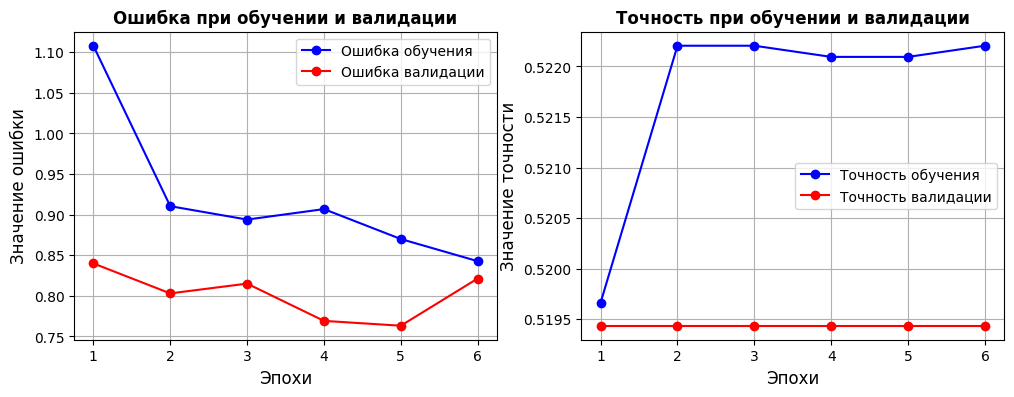

In [75]:
plot_training_curves(history)

In [77]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

89/89 [==============================] - 68s 743ms/step


In [78]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.3331
Precision_score:	0.2714
Recall_score:		0.5207
F1_score:		0.3568
AUC Score:		0.8410

Accuracy Score 0:	0.0000
Accuracy Score 1:	0.0000
Accuracy Score 2:	0.9993

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       695
           1       0.00      0.00      0.00       660
           2       0.52      1.00      0.68      1474

    accuracy                           0.52      2829
   macro avg       0.17      0.33      0.23      2829
weighted avg       0.27      0.52      0.36      2829



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

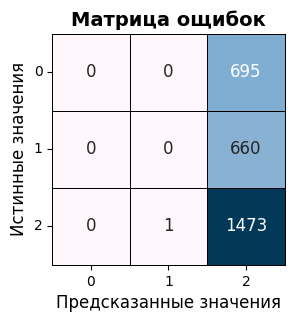

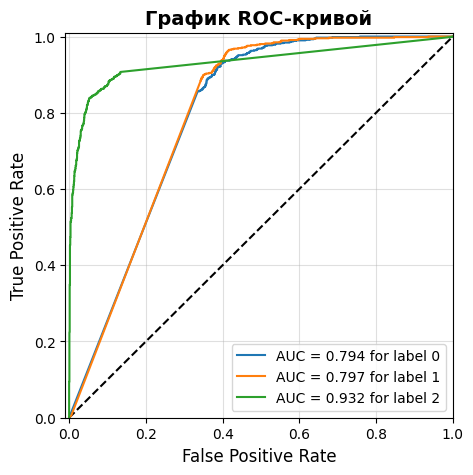

In [79]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_multiclass_roc(y_test, y_predicted_prob, 3)